# Allen Brain Cell Atlas Dataset / MERFISH Story
Subset of 4 almost consecutive slices with 372,144 cells, Subset of xxx genes.

This story is about exploring image less 2.5D point cloud.

It includes:
- Visualization of Points Cloud
- Conversion Point clouds <-> 2.5 D Polygons <-> 3D Mesh 
- Spatial Query

## Storyboard

0. Install and dowload dataset from Google Drive (ZARR with Table)
1. Imports, Functions and Constants
2. Load and display the dataset in Napari 3d
3. Controls: 
  - Slider Point size 
  - Select slices to display
  - Select feature to display
  - Slider for contrast_limits
  - Tick box for normalized and tick box for log scale
4. Create Shape 1st ans last slice
5. Shapes to point cloud Dask DataFrame
6. Delaunay Alpha shape (slider?) -> Mesh 
7. Mesh -> Section of 3D mesh
8. Select a cluster -> Create a mesh
9. Intersection
10. Select a gene and show expression


## 0. Download the data (Etienne, priority 2 = solve issue with Google Drive)

### Clone repo and create conda environment
```bash
mkdir -p ~/code/scverse
cd $_
git clone git@github.com:edoumazane/spatial-hack.git
cd ~/code/scverse/spatial-hack
conda env create -f environment.yaml
```

### If you need to update the environment
```bash
cd ~/code/scverse/spatial-hack
conda env update -f environment.yaml
```

### Download the data
```bash
cd ~/code/scverse/spatial-hack
conda env create -f environment_gdown.yaml

mkdir -p  ~/data/ST/abc_atlas/derived
cd ~/data/ST/abc_atlas/derived
conda activate gdown
# gdown "https://drive.google.com/uc?export=download&id=15kTpS4RksoiIwMnCN_cVSYqdPsaWgXOe"
```
### You're good to go if...
```bash
cd
tree -L 3 data/ST/abc_atlas/derived/Story01-ABC-MERFISH-V01.zarr
```
... shows:
```raw
data/ST/abc_atlas/derived/Story01-ABC-MERFISH-V01.zarr
├── points
│   └── cells
│       └── points.parquet
├── tables
│   └── expression
│       ├── X
│       ├── layers
│       ├── obs
│       ├── obsm
│       ├── obsp
│       ├── uns
│       ├── var
│       ├── varm
│       └── varp
└── zmetadata
```



## 1. Imports, variables and functions

In [1]:
import pandas as pd
import anndata as ad
from pathlib import Path
import spatialdata as sd
from spatialdata import SpatialData
from spatialdata.models import ShapesModel, TableModel, PointsModel
import napari
import numpy as np
import dask.dataframe as dd
from napari_spatialdata import Interactive
from ipywidgets import interact


/Users/edmz/miniconda3/envs/napari-spatialdata/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## 2. Load and display the dataset in Napari 3d (Etienne, priority 1)

In [2]:
data_dir = Path.home() / "data/st/abc_atlas/derived"
sdata = sd.read_zarr(data_dir / "Story01-ABC-MERFISH.zarr")

In [3]:
sdata

SpatialData object, with associated Zarr store: /Users/edmz/data/st/abc_atlas/derived/Story01-ABC-MERFISH.zarr
├── Points
│     └── 'cells': DataFrame with shape: (<Delayed>, 14) (3D points)
└── Tables
      └── 'expression': AnnData (372144, 10)
with coordinate systems:
    ▸ 'global', with elements:
        cells (Points)

In [4]:
df_features = sdata["cells"].compute()
display(df_features.shape)
df_features.head(3)

(372144, 14)

abc_sample_id          class  \
cell_label                                                                   
1017155956100220013    e68e6b9a-5f45-4cab-925c-49ab53facda3    33 Vascular   
1017155956100220014    8b05edb7-a376-43fb-912d-8de493df9269    33 Vascular   
1017155956100220015-1  e5367b52-c694-4b17-80a5-b09c453a9e42  30 Astro-Epen   

                      class_color             cluster cluster_color  \
cell_label                                                            
1017155956100220013       #858881       5295 ABC NN_1       #26FFE8   
1017155956100220014       #858881      5297 VLMC NN_1       #660F4A   
1017155956100220015-1     #594a26  5219 Astro-TE NN_1       #C3CC7A   

                      neurotransmitter neurotransmitter_color  \
cell_label                                                      
1017155956100220013                                   #666666   
1017155956100220014                                   #666666   
1017155956100220015-1                                 #666666   

                              subclass subclass_color           supertype  \
cell_label                                                                  
1017155956100220013         329 ABC NN        #CC5CC1       1186 ABC NN_1   
1017155956100220014        330 VLMC NN        #653D66      1187 VLMC NN_1   
1017155956100220015-1  319 Astro-TE NN        #3DCCB1  1161 Astro-TE NN_1   

                      supertype_color         x         y    z  
cell_label                                                      
1017155956100220013           #553D66  1.714652  4.240140  9.6  
1017155956100220014           #66391F  1.681030  4.276353  9.6  
1017155956100220015-1         #FFB173  1.709386  4.250322  9.6

In [5]:
adata = sdata["expression"]
display(adata)
display(adata.obs.head(3))
display(adata.var.head(3))
display(adata.to_df().head(3))

AnnData object with n_obs × n_vars = 372144 × 10
    obs: 'brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'abc_sample_id', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color'

brain_section_label  cluster_alias  \
cell_label                                                 
1104095349102280703     C57BL6J-638850.52           1258   
1017155956100650356     C57BL6J-638850.50           1258   
1104095349102440200-3   C57BL6J-638850.52           1258   

                       average_correlation_score feature_matrix_label  \
cell_label                                                              
1104095349102280703                     0.527005       C57BL6J-638850   
1017155956100650356                     0.691000       C57BL6J-638850   
1104095349102440200-3                   0.669169       C57BL6J-638850   

                          donor_label donor_genotype donor_sex         x  \
cell_label                                                                 
1104095349102280703    C57BL6J-638850          wt/wt         M  7.644348   
1017155956100650356    C57BL6J-638850          wt/wt         M  7.889727   
1104095349102440200-3  C57BL6J-638850          wt/wt         M  7.806380   

                              y    z  ... neurotransmitter           class  \
cell_label                            ...                                    
1104095349102280703    7.696379  9.8  ...             GABA  05 OB-IMN GABA   
1017155956100650356    7.462066  9.4  ...             GABA  05 OB-IMN GABA   
1104095349102440200-3  7.547507  9.8  ...             GABA  05 OB-IMN GABA   

                                       subclass                    supertype  \
cell_label                                                                     
1104095349102280703    039 OB Meis2 Thsd7b Gaba  0143 OB Meis2 Thsd7b Gaba_1   
1017155956100650356    039 OB Meis2 Thsd7b Gaba  0143 OB Meis2 Thsd7b Gaba_1   
1104095349102440200-3  039 OB Meis2 Thsd7b Gaba  0143 OB Meis2 Thsd7b Gaba_1   

                                           cluster neurotransmitter_color  \
cell_label                                                                  
1104095349102280703    0518 OB Meis2 Thsd7b Gaba_1                #FF3358   
1017155956100650356    0518 OB Meis2 Thsd7b Gaba_1                #FF3358   
1104095349102440200-3  0518 OB Meis2 Thsd7b Gaba_1                #FF3358   

                      class_color subclass_color supertype_color cluster_color  
cell_label                                                                      
1104095349102280703       #1b4332        #FF99F7         #9F00CC       #994945  
1017155956100650356       #1b4332        #FF99F7         #9F00CC       #994945  
1104095349102440200-3     #1b4332        #FF99F7         #9F00CC       #994945  

[3 rows x 21 columns]

Empty DataFrame
Columns: []
Index: [0, 1, 2]

0  1  2  3  4  5  6  7  8  9
cell_label                                         
1104095349102280703    1  3  5  1  3  6  6  6  7  9
1017155956100650356    1  7  4  1  9  0  7  5  3  2
1104095349102440200-3  0  6  1  2  0  5  6  7  5  1

#### With `napari-spatialdata`
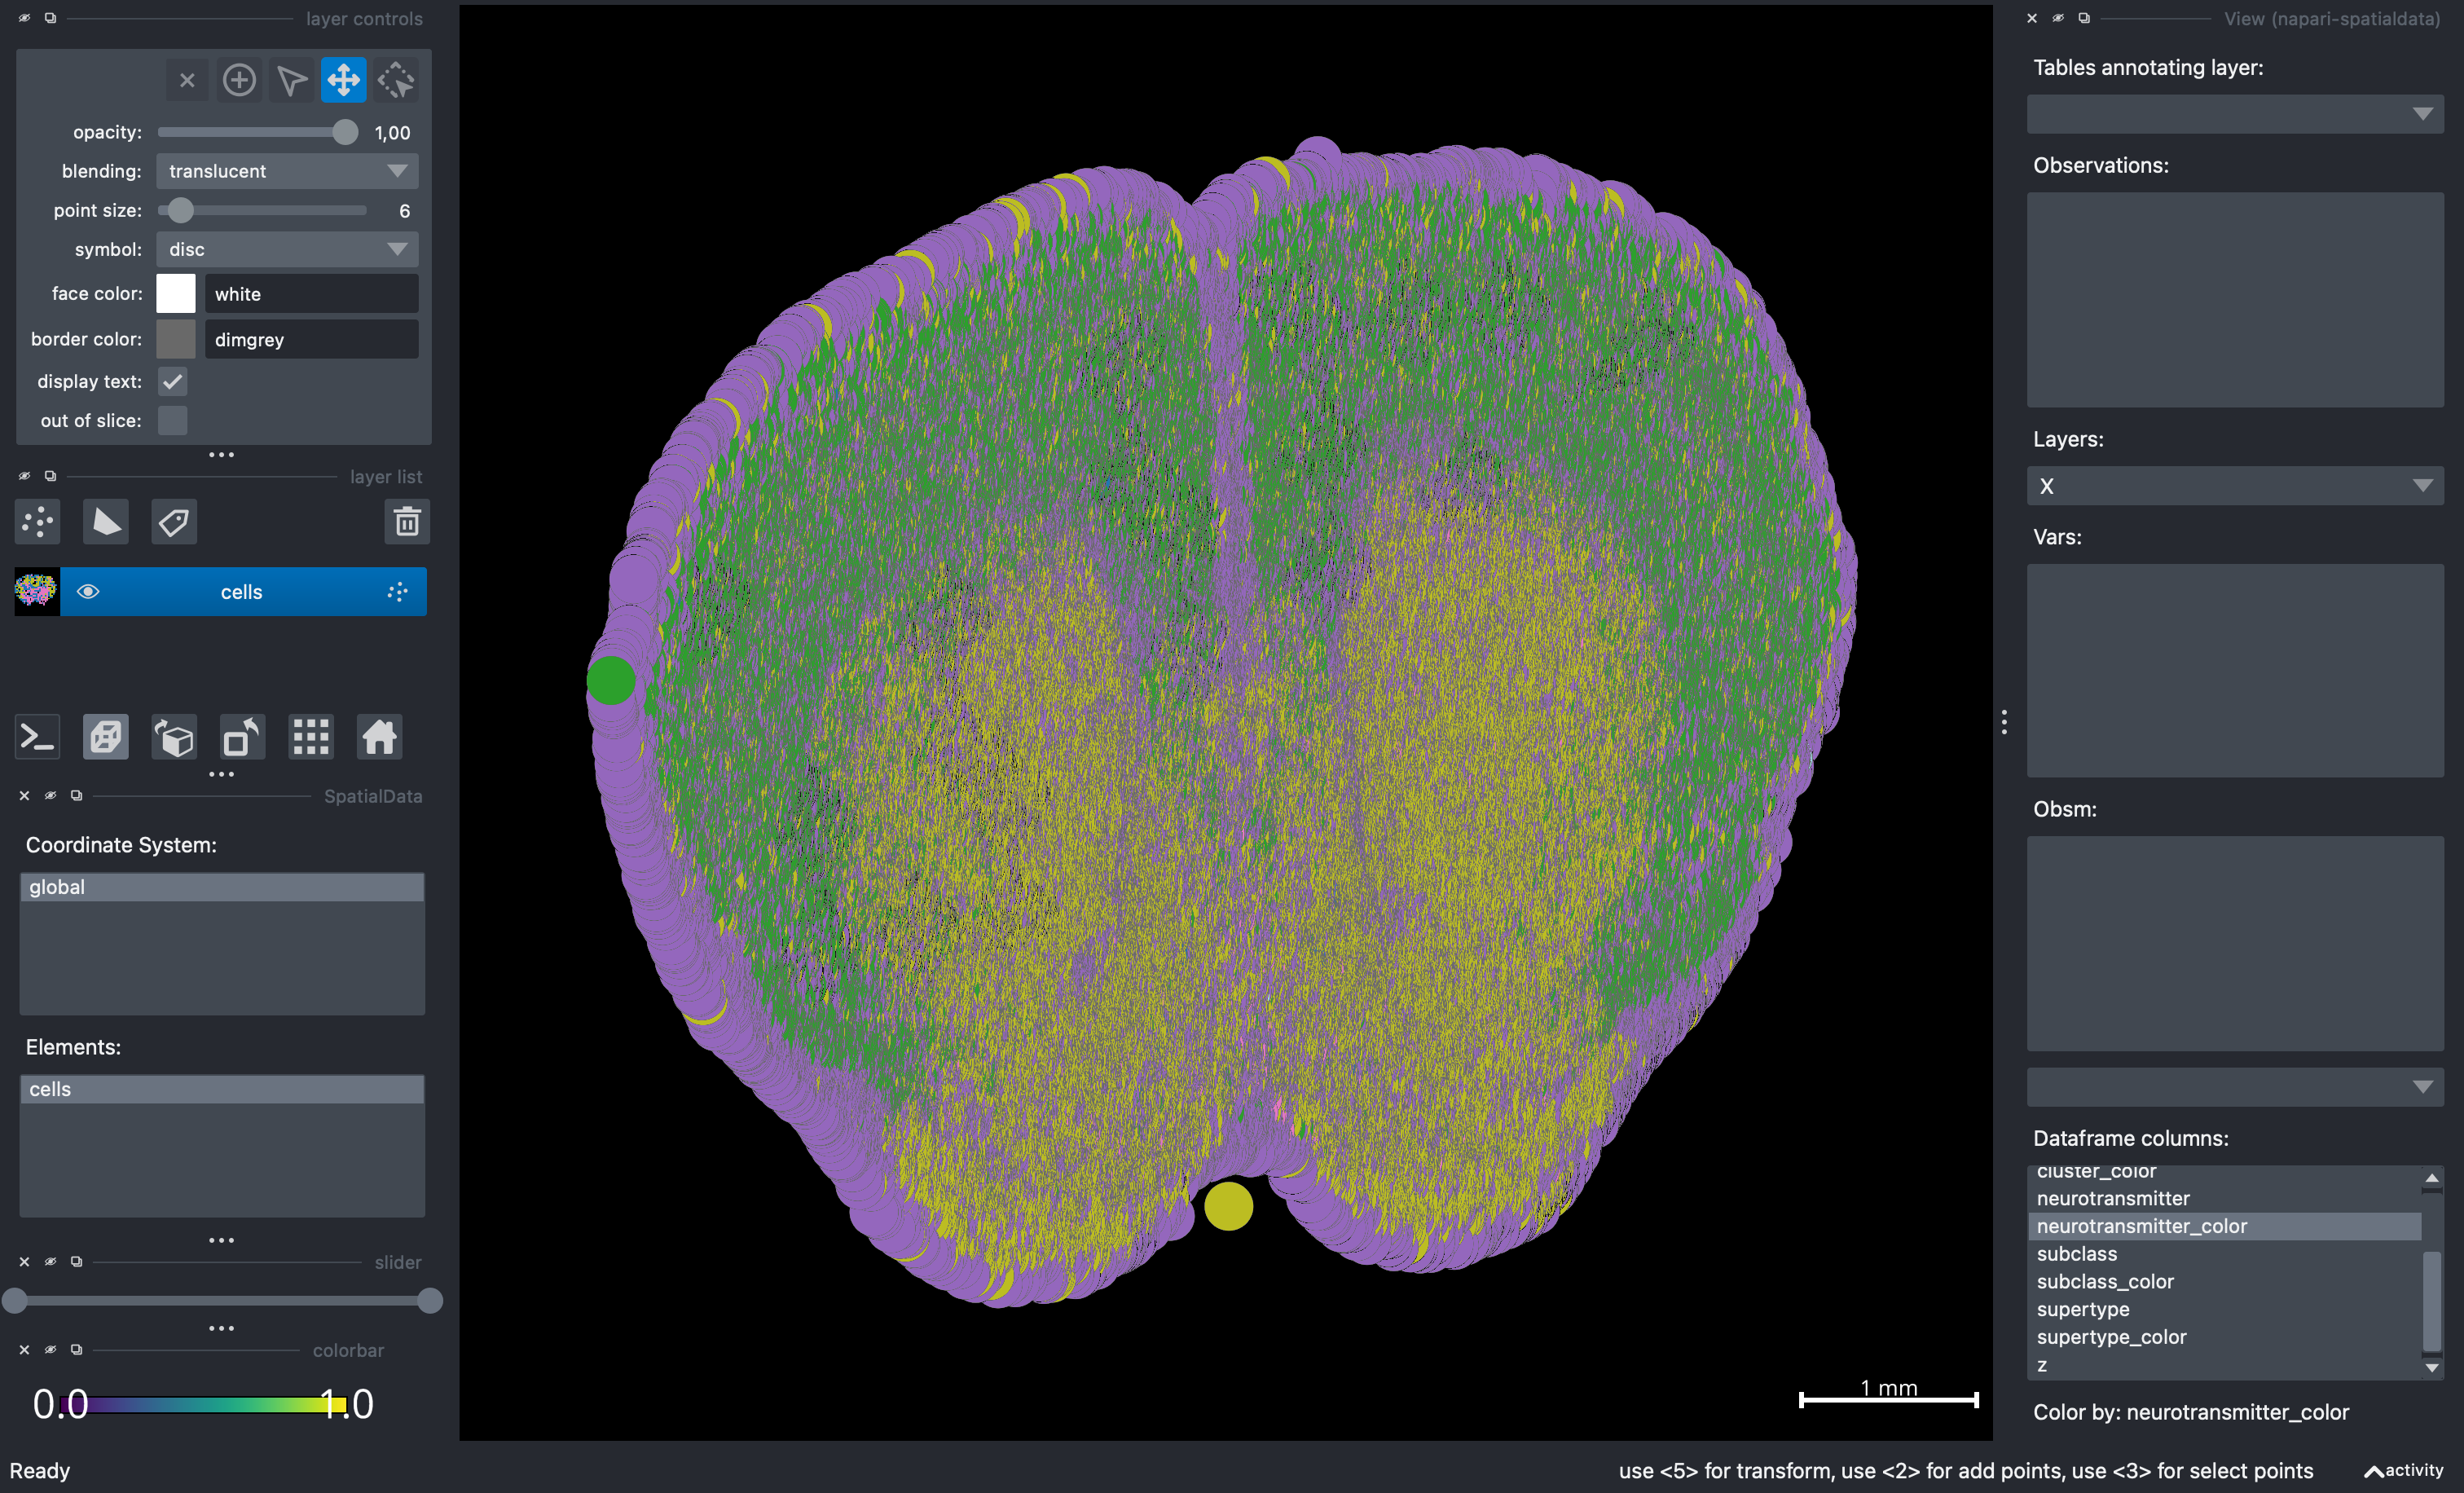

In [6]:
interactive = Interactive(sdata)
interactive.run()

2025-03-19 08:22:36.086 python[91226:3546197] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-19 08:22:36.086 python[91226:3546197] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2025-03-19 08:22:41.364 | INFO     | napari_spatialdata._viewer:get_sdata_points:710 - Subsampling points because the number of points exceeds the currently supported 100000. You can change this threshold with ```from napari_spatialdata.constants import config
config.POINT_THRESHOLD = <new_threshold>```
2025-03-19 08:22:41.600 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.


In [58]:
viewer = napari.current_viewer()

# Works
viewer.dims.ndisplay = 3
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "mm"
viewer.layers["cells"].border_width=0.01
point_size = 1
viewer.layers["cells"].point_size = np.ones(len(viewer.layers["cells"].data), dtype=int) * point_size


In [57]:
# WHY????
display(df_features.shape)
display(adata.obs.shape)
display(viewer.layers["cells"].data.shape)

(372144, 14)

(372144, 21)

(100000, 2)

In [50]:
viewer.layers["cells"].ndim = 3

AttributeError: property 'ndim' of 'Points' object has no setter

In [53]:
# viewer.layers["cells"].data =

new_data = np.hstack([df_features[["z"]].values[:100000], viewer.layers["cells"].data])
display(new_data.shape)
display(new_data)
viewer.layers["cells"].data = new_data

(100000, 3)

array([[9.6       , 4.33138568, 1.6439978 ],
       [9.6       , 4.32948491, 1.65371432],
       [9.6       , 4.4243462 , 1.57645865],
       ...,
       [9.4       , 5.06885577, 9.74673189],
       [9.4       , 5.04547883, 9.7548297 ],
       [9.4       , 5.08279217, 9.74657222]])

ValueError: Points dimensions must be equal to ndim

In [59]:
viewer.layers["cells"].scale = (0.2, 1, 1)

ValueError: could not broadcast input array from shape (3,) into shape (2,)

In [60]:
viewer.close()

2025-03-19 08:41:27.156 | DEBUG    | napari_spatialdata._view:_on_layer_update:569 - Updating layer.


#### With pure `napari`

In [106]:
try:
    v.add_points(np.ones((100, 3)), name="dont name anything like this")
    del v.layers["dont name anything like this"]
except:
    v = napari.Viewer(title="MERFISH")

v.dims.ndisplay = 3
v.scale_bar.visible = True
v.scale_bar.unit = "um"

In [112]:
def add_points(v, df_features, layer_name="cells"):
    cols_oi = ['neurotransmitter', 'class', 'subclass',
       'supertype', 'cluster', 'neurotransmitter_color', 'class_color',
       'subclass_color', 'supertype_color', 'cluster_color']
    v.add_points(df_features[["z", "y", "x"]].values*1e3,
                name=layer_name,
                size=20,
                scale=(0.2,1,1),
                properties=df_features[cols_oi],
                face_color=df_features["class_color"].to_list(),
                border_color="#00000000")
    return v

In [113]:
add_points(v, df_features)

Viewer(camera=Camera(center=(np.float64(1960.0), np.float64(5529.380728545668), np.float64(5560.708329635792)), zoom=np.float64(0.1241316649307851), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(np.float64(4388.203358154776), np.float64(5625.841876777356), 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=3, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(1880.0), stop=np.float64(2040.0), step=np.float64(0.2)), RangeTuple(start=np.float64(2168.161948604719), stop=np.float64(8890.599508486615), step=np.float64(1.0)), RangeTuple(start=np.float64(1157.6960106346892), stop=np.float64(9963.720648636896), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(1960.0), np.float64(5529.161948604718), np.float64(5560.696010634689)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1),

## 3. Viz controllers (Priority 2)

### 3.1 Slider Point size (prority 2)

In [121]:
@interact
def change_point_size(size=(1, 100)):
    for layer in v.layers:
        if layer.visible:
            layer.size = size

interactive(children=(IntSlider(value=50, description='size', min=1), Output()), _dom_classes=('widget-interac…

### 3.2 Select slices to display (Priority 1)

In [118]:
available_slices = df_features["brain_section_label"].unique().tolist()
@interact
def select_slice(slice=available_slices):
    for layer in v.layers:
        if layer.name in available_slices:
            v.layers.remove(layer)
        if "cells" in layer.name:
            layer.visible = False
    df_features_subset = df_features.query("brain_section_label == @slice")
    add_points(v, df_features_subset, layer_name=slice)

interactive(children=(Dropdown(description='slice', options=('C57BL6J-638850.51', 'C57BL6J-638850.50', 'C57BL6…

### 3.3 Select feature to display

### 3.4 Slider for contrast_limits

### 3.5 Tick box for normalized and tick box for log scale

## 4. Create Shape 1st and last slice (Priority 1)

## 5. Shapes to point cloud Dask DataFrame (Priority 1)

https://stackoverflow.com/questions/69110871/alpha-shapes-in-3d-follow-up

https://stackoverflow.com/questions/78252343/how-can-i-generate-a-concave-hull-of-3d-points

## 6. Delaunay Alpha shape (slider?) -> Mesh (Priority 1)

## 7. Mesh -> Section of 3D mesh (Priority 1)

## 8. Select a cluster -> Create a mesh (Priority 2)

## 9. Intersection of two meshes (Priority 2)

## 10. Stats within a mesh (table of distribution by cluster, stats of gene expression...) (Priority 3)